# 1) Load Dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Step 1: Load Dataset
csv_path = "../../data/hotel_bookings.csv"

df = pd.read_csv(csv_path)
df.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# 2) BEFORE CLEANING - Missing Values Overview

Missing values PER COLUMN (before cleaning):
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent       

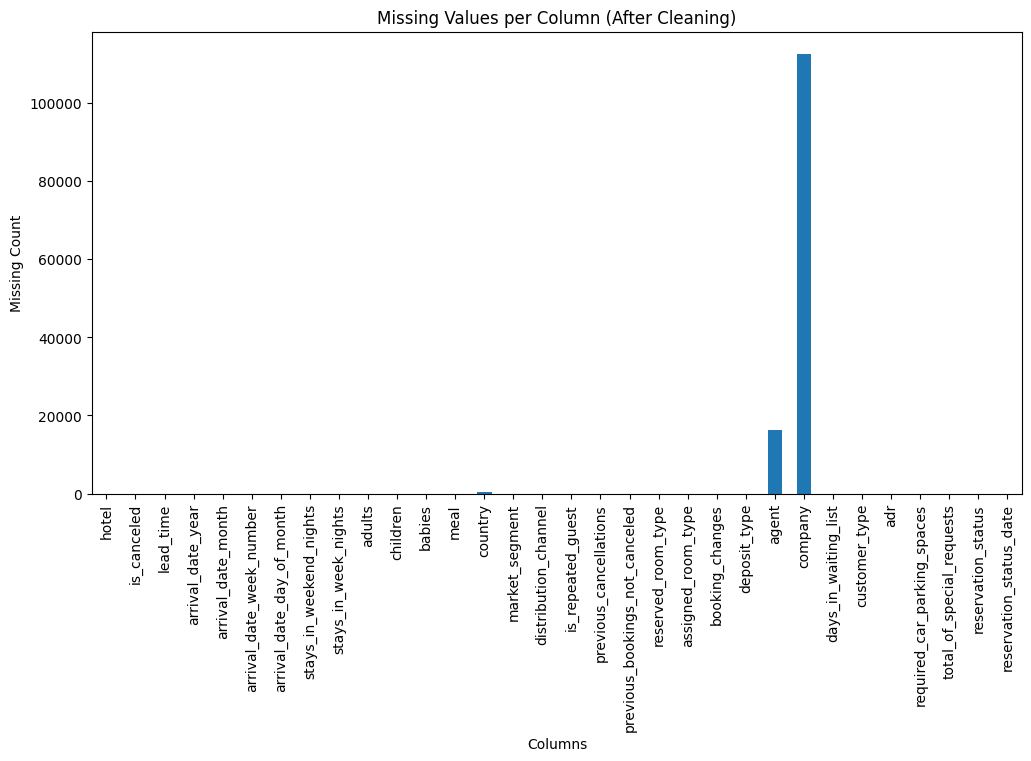

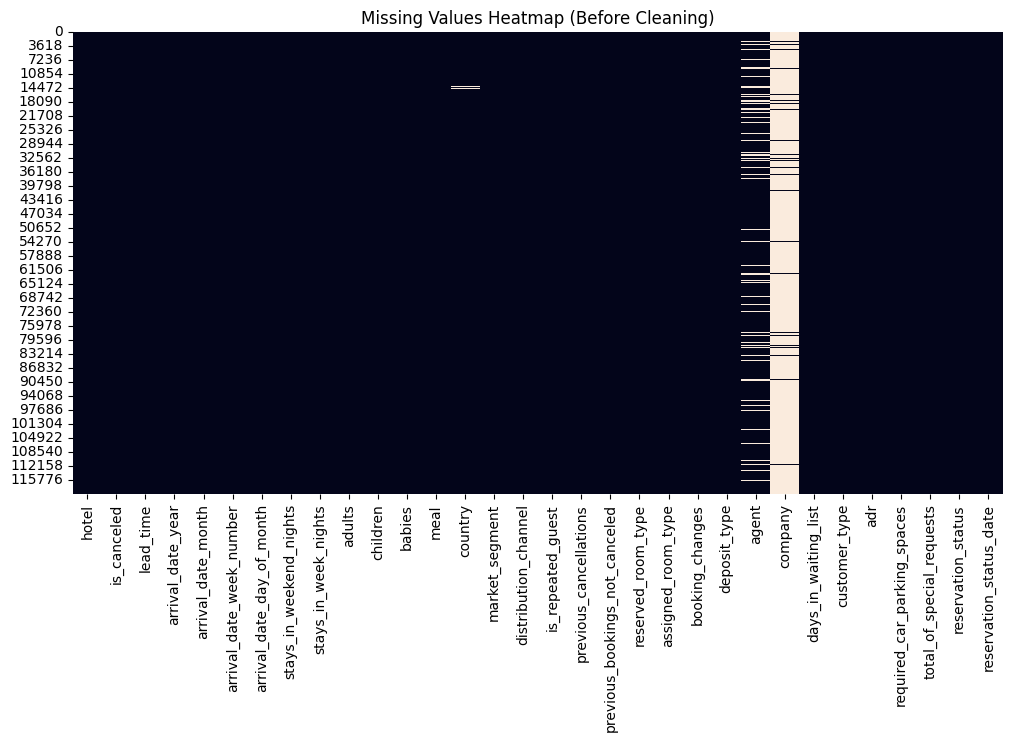

In [2]:

print("Missing values PER COLUMN (before cleaning):")
print(df.isna().sum())

print("\nTotal missing before cleaning:", df.isna().sum().sum())

plt.figure(figsize=(12,6))
df.isna().sum().plot(kind='bar')
plt.title("Missing Values per Column (After Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Missing Count")
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (Before Cleaning)")
plt.show()

# 3) Handle Missing Values

In [3]:

df["children"] = df["children"].fillna(0)
df["country"] = df["country"].fillna("Unknown")
df["agent"] = df["agent"].fillna(0)
df["company"] = df["company"].fillna(0)

print("\nMissing values handled.")


Missing values handled.


# 4) AFTER CLEANING - Missing Values Check


Missing values PER COLUMN (after cleaning):
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type      

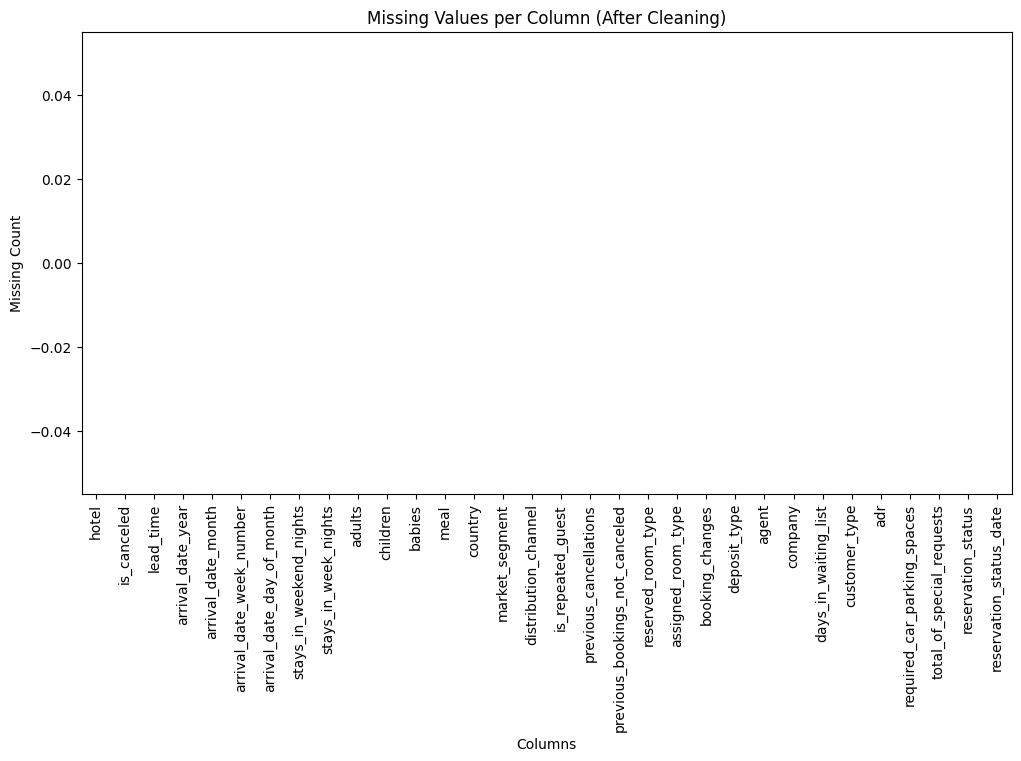

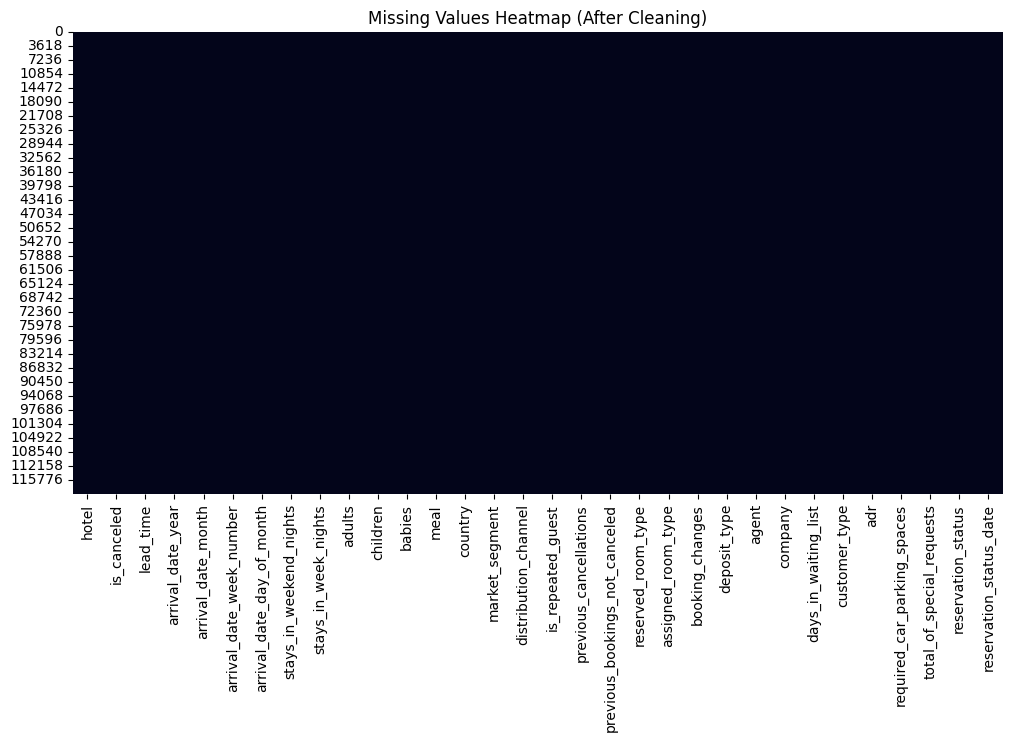

In [4]:

print("\nMissing values PER COLUMN (after cleaning):")
print(df.isna().sum())

print("\nTotal missing after cleaning:", df.isna().sum().sum())

plt.figure(figsize=(12,6))
df.isna().sum().plot(kind='bar')
plt.title("Missing Values per Column (After Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Missing Count")
plt.show()


plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Values Heatmap (After Cleaning)")
plt.show()

# 5) Remove Invalid Rows (Bookings with no guests)

In [5]:

invalid_rows = (df["adults"] == 0) & (df["children"] == 0) & (df["babies"] == 0)
print("Number of invalid rows with no guests:", invalid_rows.sum())

df = df[~invalid_rows]
print("Shape after removing invalid rows:", df.shape)

Number of invalid rows with no guests: 180
Shape after removing invalid rows: (119210, 32)


# 6) Create Derived Variables

In [6]:

df["total_guests"] = df["adults"] + df["children"] + df["babies"]
df["total_nights"] = df["stays_in_weekend_nights"] + df["stays_in_week_nights"]

df["arrival_date"] = pd.to_datetime(
    df["arrival_date_year"].astype(str) + "-" +
    df["arrival_date_month"].astype(str) + "-" +
    df["arrival_date_day_of_month"].astype(str),
    errors="coerce"
)

df = df.dropna(subset=["arrival_date"])

df["arrival_month"] = df["arrival_date"].dt.month
df["arrival_weekday"] = df["arrival_date"].dt.day_name()

print("\nDerived variables created.")
print(df[["total_guests", "total_nights", "arrival_date"]].head())


Derived variables created.
   total_guests  total_nights arrival_date
0           2.0             0   2015-07-01
1           2.0             0   2015-07-01
2           1.0             1   2015-07-01
3           1.0             1   2015-07-01
4           2.0             2   2015-07-01


# 7) Basic Validation

In [7]:
class DataValidationError(Exception):
    """Custom exception for data validation errors."""
    pass


if df.empty:
    raise DataValidationError("Dataset became empty after cleaning.")

if not df["is_canceled"].isin([0, 1]).all():
    raise DataValidationError("Invalid values found in is_canceled column.")

if (df["total_guests"] <= 0).any():
    raise DataValidationError("Found rows with zero or negative guests.")

if (df["total_nights"] < 0).any():
    raise DataValidationError("Found negative night counts.")

if not pd.api.types.is_datetime64_any_dtype(df["arrival_date"]):
    raise DataValidationError("arrival_date is not datetime type.")

print("\nValidation passed successfully.")


Validation passed successfully.


# 8) Saving Cleaned df

In [8]:
OUTPUT_PATH = "../../data/hotel_bookings_clean.csv"
df.to_csv(OUTPUT_PATH, index=False)

print(f"Cleaned dataset saved to {OUTPUT_PATH}")


Cleaned dataset saved to ../../data/hotel_bookings_clean.csv
